<a href="https://colab.research.google.com/github/quekhyg/NLP-Lyric-Generator/blob/main/GRU_word_level_allstructures_TL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NDP Song Lyric Generation (using RNN LSTM)

_Inspired by [Text generation with an RNN](https://www.tensorflow.org/tutorials/text/text_generation)_

In [1]:
!git clone https://<username>:<token>y@github.com/quekhyg/NLP-Lyric-Generator.git

Cloning into 'NLP-Lyric-Generator'...
remote: Enumerating objects: 554, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 554 (delta 4), reused 14 (delta 4), pack-reused 538
Receiving objects: 100% (554/554), 976.95 MiB | 29.88 MiB/s, done.
Resolving deltas: 100% (180/180), done.


In [2]:
%cd /content/NLP-Lyric-Generator

/content/NLP-Lyric-Generator


In [3]:
!pip install rouge

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!pip install spacy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Import dependencies

In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import platform
import time
import pathlib
import os
import re
import sys

import nltk
from nltk.tokenize import word_tokenize
nltk.download("stopwords")
from nltk.corpus import stopwords
from wordcloud import WordCloud
from PIL import Image
from sklearn.model_selection import train_test_split
from gensim import downloader

#GitHub packages
import src.lib.utilities as utils
from src.lib.sentiment import Sentiment
from src.lib.bleu_rouge import bleu_rouge

print('Python version:', platform.python_version())
print('Tensorflow version:', tf.__version__)
print('Keras version:', tf.keras.__version__)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
Python version: 3.7.13
Tensorflow version: 2.8.2
Keras version: 2.8.0


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [6]:
tf.random.set_seed(2022)

import json
with open('./output/prompt_ref.json') as f:
    prompt_ref = json.load(f)

## Get data

In [7]:
PATH = './data/'

In [8]:
#Utils has instantiated the seed to be 2022 by default
train_corpus, val_corpus, train_files, val_files = utils.split_corpus(path = PATH, end_song_token = '\n\n\n')

In [9]:
sorted(val_files)

['I Love Singapore.txt',
 'Lifestory.txt',
 'Love at First Light.txt',
 'My People My Home.txt',
 'My Singapore Story.txt',
 'One United People.txt',
 'Voices From The Heart.txt',
 'We Are The Ones.txt',
 'We Will Get There.txt',
 'We are Singapore.txt']

## Analyze the dataset

In [10]:
print('Length of Corpus: {} characters'.format(len(train_corpus)))

Length of Corpus: 45090 characters


In [11]:
# Take a look at the first 1000 characters in text.
print(train_corpus[:500])

<VERSE>
Raise your head to the skies
This is how we all begin
See the fire in your eyes
Feel the yearning deep within
Take a leap and you will fly
With all the wishes that you own
Make your dreams light up the sky
Home is where you are not alone

<PRECHORUS>
And our hearts will beat together
Echoing what dreams may come
Walking tall in any weather
Time has come bang the drum
Cause tomorrow's here today

<CHORUS>
Dream away
Take the world by the hand
Cause tomorrow's here today
Dream away
Come le


In [12]:
# clean corpus
def clean_tokenize_corpus(corpus):
  corpus_clean = utils.decontraction(corpus)
  corpus_clean = utils.remove_punct(corpus_clean, '\<|\>')

  # tokenize and count the number of words
  corpus_clean = re.sub('\n\n', '\n', corpus_clean)
  corpus_clean = re.sub('\n', ' \n ', corpus_clean)
  tokens = re.split(' ', corpus_clean)
  tokens_clean = []
  structures = ['<BRIDGE>', '<CHORUS>', '<OTHERS>', '<PRECHORUS>', '<PRELUDE>', '<VERSE>']
  for i,t in enumerate(tokens):
      if t:                                  # remove empty strings
          if i < len(tokens)-1 and t == '\n' and tokens[i+1] in structures:
              tokens_clean.append('\n\n')    # change to double line break for token before structure 
          elif t not in structures:
              tokens_clean.append(t.lower()) # lower case if not structure tokens
          else:
              tokens_clean.append(t)

  return tokens_clean


train_tokens_clean = clean_tokenize_corpus(train_corpus)
val_tokens_clean = clean_tokenize_corpus(val_corpus)

print('Length of Train Corpus: {} words'.format(len(train_tokens_clean)))
# The unique words in the file
vocab = sorted(set(train_tokens_clean))
print('Vocab Size:', len(vocab))
print('Vocab Examples:', train_tokens_clean[:20])
print('')

print('Length of Validation Corpus: {} words'.format(len(val_tokens_clean)))
# The unique words in the file
val_vocab = sorted(set(val_tokens_clean))
print('Vocab Size:', len(val_vocab))
print('Vocab Examples:', val_tokens_clean[:20])



Length of Train Corpus: 10735 words
Vocab Size: 921
Vocab Examples: ['<VERSE>', '\n', 'raise', 'your', 'head', 'to', 'the', 'skies', '\n', 'this', 'is', 'how', 'we', 'all', 'begin', '\n', 'see', 'the', 'fire', 'in']

Length of Validation Corpus: 2797 words
Vocab Size: 441
Vocab Examples: ['<VERSE>', '\n', 'one', 'singapore', '\n', 'one', 'people', 'strong', 'and', 'free', '\n', 'with', 'one', 'heart', 'one', 'voice', '\n', 'we', 'make', 'our']


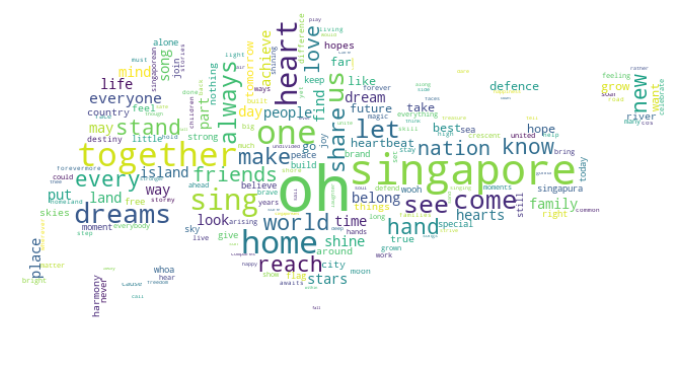

In [13]:
# Unigram Word Cloud

# remove stopwords
stop = set(stopwords.words('english'))
structures = ['<BRIDGE>', '<CHORUS>', '<OTHERS>', '<PRECHORUS>', '<PRELUDE>', '<VERSE>']
stop.update(structures)
stop.update(['\n', '\n\n'])
tokens_no_stopwords = [t for t in train_tokens_clean if t not in stop]

corpus_dict = {}
for word in tokens_no_stopwords:
    corpus_dict[word] = corpus_dict.get(word, 0) + 1

sg_mask = np.array(Image.open("./images/singaporemap.png"))
my_cloud = WordCloud(background_color='white', stopwords=stop, mask=sg_mask).generate_from_frequencies(corpus_dict)

plt.figure(figsize=(12,10))
plt.imshow(my_cloud, interpolation='bilinear') 
plt.axis('off')
plt.show()

## Process the dataset

### Vectorize the text

Before feeding the text to our RNN we need to convert the text from a sequence of characters to a sequence of numbers. To do so we will detect all unique characters in the text, form a vocabulary out of it and replace each character with its index in the vocabulary.

In [14]:
# get word and indices mapping
word_indices = {}
indices_word = {}
word_indices['<OOV>'] = 0
indices_word[0] = '<OOV>'
for i, w in enumerate(sorted(set(train_tokens_clean)), start=1):
# for i, w in enumerate(sorted(set(train_tokens_clean))):
    word_indices[w] = i
    indices_word[i] = w

In [15]:
list(word_indices.items())[:10]

[('<OOV>', 0),
 ('\n', 1),
 ('\n\n', 2),
 ('<BRIDGE>', 3),
 ('<CHORUS>', 4),
 ('<OTHERS>', 5),
 ('<PRECHORUS>', 6),
 ('<PRELUDE>', 7),
 ('<VERSE>', 8),
 ('a', 9)]

In [16]:
list(indices_word.items())[:10]

[(0, '<OOV>'),
 (1, '\n'),
 (2, '\n\n'),
 (3, '<BRIDGE>'),
 (4, '<CHORUS>'),
 (5, '<OTHERS>'),
 (6, '<PRECHORUS>'),
 (7, '<PRELUDE>'),
 (8, '<VERSE>'),
 (9, 'a')]

In [17]:
# convert data to indices numbers (vectorize):
train_tokens_clean = np.array(train_tokens_clean)
train_tokens_clean_idx = np.vectorize(word_indices.get)(train_tokens_clean)

val_tokens_clean = np.array(val_tokens_clean)
val_tokens_clean_idx = np.array([word_indices.get(token, 0) for token in val_tokens_clean])

### Create sequences

In [18]:
word_dataset = tf.data.Dataset.from_tensor_slices(train_tokens_clean_idx)

In [19]:
SEQUENCE_LEN = 15
sequences = word_dataset.window(SEQUENCE_LEN + 1, 1, drop_remainder=True)

for window in sequences.take(3):
    print(repr(' '.join(np.vectorize(indices_word.get)(np.array(list(window.as_numpy_iterator()))))))

'<VERSE> \n raise your head to the skies \n this is how we all begin \n'
'\n raise your head to the skies \n this is how we all begin \n see'
'raise your head to the skies \n this is how we all begin \n see the'


In [20]:
sequences = sequences.flat_map(lambda window: window.batch(SEQUENCE_LEN + 1))
for elem in sequences.take(3):
    print(elem)

tf.Tensor([  8   1 589 916 353 787 764 673   1 776 396 384 861  26  71   1], shape=(16,), dtype=int64)
tf.Tensor([  1 589 916 353 787 764 673   1 776 396 384 861  26  71   1 635], shape=(16,), dtype=int64)
tf.Tensor([589 916 353 787 764 673   1 776 396 384 861  26  71   1 635 764], shape=(16,), dtype=int64)


In [21]:
sequences = sequences.map(lambda window: (window[:-1], window[-1:]))
X_train = sequences.map(lambda X,y: X)
y_train = sequences.map(lambda X,y: y)

for elem1, elem2 in zip(X_train.take(3), y_train.take(3)):
    print(elem1, '----->', elem2)

tf.Tensor([  8   1 589 916 353 787 764 673   1 776 396 384 861  26  71], shape=(15,), dtype=int64) -----> tf.Tensor([1], shape=(1,), dtype=int64)
tf.Tensor([  1 589 916 353 787 764 673   1 776 396 384 861  26  71   1], shape=(15,), dtype=int64) -----> tf.Tensor([635], shape=(1,), dtype=int64)
tf.Tensor([589 916 353 787 764 673   1 776 396 384 861  26  71   1 635], shape=(15,), dtype=int64) -----> tf.Tensor([764], shape=(1,), dtype=int64)


In [22]:
def get_sequences(tokens_idx, sequence_len):
  word_dataset = tf.data.Dataset.from_tensor_slices(tokens_idx)
  sequences = word_dataset.window(sequence_len + 1, 1, drop_remainder=True)
  sequences = sequences.flat_map(lambda window: window.batch(sequence_len + 1))
  sequences = sequences.map(lambda window: (window[:-1], window[-1:]))

  return sequences

SEQUENCE_LEN = 15
train_sequences = get_sequences(train_tokens_clean_idx, SEQUENCE_LEN)
val_sequences = get_sequences(val_tokens_clean_idx, SEQUENCE_LEN)

In [23]:
print('train dataset size: {}'.format(len(list(train_sequences.as_numpy_iterator()))))

train dataset size: 10720


In [24]:
dataset_size = len(list(train_sequences.as_numpy_iterator()))
print('train dataset size: {}'.format(dataset_size))

dataset_size = len(list(val_sequences.as_numpy_iterator()))
print('val dataset size: {}'.format(dataset_size))

train dataset size: 10720
val dataset size: 2782


In [25]:
BATCH_SIZE = 64

# Buffer size to shuffle the dataset (TF data is designed to work
# with possibly infinite sequences, so it doesn't attempt to shuffle
# the entire sequence in memory. Instead, it maintains a buffer in
# which it shuffles elements).
BUFFER_SIZE = 10000

AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_sequences.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True).cache().prefetch(buffer_size=AUTOTUNE)
val_dataset = val_sequences.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True).cache().prefetch(buffer_size=AUTOTUNE)

print('Batched dataset size: {}'.format(len(list(train_dataset.as_numpy_iterator()))))

Batched dataset size: 167


### Build and Test Model

In [26]:
VOCAB_SIZE = len(word_indices)
EMBEDDINGG_DIM = 128
RNN_UNITS = 512

EPOCHS=50
LR = 0.001

In [27]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    """Build Keras Model

    Args: 
      vocab_size (int): size of vocabulary of corpus
      embedding_dim (int): dimension of word embedding matrix
      rnn_units (int): number of neurons in rnn
      batch_size (int): batch size 

    
    Returns:
      Keras sequential model 
    """
    
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Embedding(
      input_dim=vocab_size,
      output_dim=embedding_dim,
      batch_input_shape=[batch_size, None]
    ))

    model.add(tf.keras.layers.LSTM(
      units=rnn_units,
      return_sequences=False,
#       stateful=True,
      recurrent_initializer=tf.keras.initializers.GlorotNormal()
    ))

    model.add(tf.keras.layers.Dense(vocab_size))
  
    return model


model = build_model(VOCAB_SIZE, EMBEDDINGG_DIM, RNN_UNITS, BATCH_SIZE)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (64, None, 128)           118016    
                                                                 
 lstm (LSTM)                 (64, 512)                 1312768   
                                                                 
 dense (Dense)               (64, 922)                 472986    
                                                                 
Total params: 1,903,770
Trainable params: 1,903,770
Non-trainable params: 0
_________________________________________________________________


In [28]:
for input_example_batch, target_example_batch in train_dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 922) # (batch_size, sequence_length, vocab_size)


In [29]:
# An objective function.
# The function is any callable with the signature scalar_loss = fn(y_true, y_pred).
def loss(labels, logits):
    """Compute the loss from outputed logits of model

    Args: 
      labels (list): y labels / ground truth
      logits (list): logits outputed by the model
    
    Returns:
      Loss score
    """
    
    return tf.keras.losses.sparse_categorical_crossentropy(
      y_true=labels,
      y_pred=logits,
      from_logits=True
    )

example_batch_loss = loss(target_example_batch, example_batch_predictions)

print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (64, 922)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       6.8262806


In [30]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=LR)
model.compile(
    optimizer=adam_optimizer,
    loss=loss
)

In [31]:
# # Directory where the checkpoints will be saved.
# checkpoint_dir = 'tmp/checkpoints'
# os.makedirs(checkpoint_dir, exist_ok=True)

# # Name of the checkpoint files
# checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt_{epoch}')

# checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
#     filepath=checkpoint_prefix,
#     save_weights_only=True
# )

### Train Model

In [32]:
history = model.fit(
  x=train_dataset,
  epochs=EPOCHS,
  validation_data=val_dataset,
)

Epoch 1/50
167/167 [==============================] - 5s 14ms/step - loss: 5.2228 - val_loss: 5.1758
Epoch 2/50
167/167 [==============================] - 1s 7ms/step - loss: 4.6472 - val_loss: 4.9495
Epoch 3/50
167/167 [==============================] - 1s 6ms/step - loss: 4.1505 - val_loss: 4.8423
Epoch 4/50
167/167 [==============================] - 1s 6ms/step - loss: 3.6856 - val_loss: 4.8193
Epoch 5/50
167/167 [==============================] - 1s 7ms/step - loss: 3.2483 - val_loss: 4.7435
Epoch 6/50
167/167 [==============================] - 1s 6ms/step - loss: 2.8114 - val_loss: 4.8058
Epoch 7/50
167/167 [==============================] - 1s 6ms/step - loss: 2.3832 - val_loss: 4.8888
Epoch 8/50
167/167 [==============================] - 1s 6ms/step - loss: 1.9985 - val_loss: 4.9181
Epoch 9/50
167/167 [==============================] - 1s 6ms/step - loss: 1.6602 - val_loss: 4.9798
Epoch 10/50
167/167 [==============================] - 1s 7ms/step - loss: 1.3940 - val_loss: 5.017

### The prediction loop

The following code block generates the text:

- It Starts by choosing a start string, initializing the RNN state and setting the number of words to generate.

- Get the prediction distribution of the next word using the start string and the RNN state.

- Then, use a categorical distribution to calculate the index of the predicted character. Use this predicted word as our next input to the model.

- The RNN state returned by the model is fed back into the model so that it now has more context, instead than only one word. After predicting the next word, the modified RNN states are again fed back into the model, which is how it learns as it gets more context from the previously predicted words.

In [33]:
def generate_text(model, start_string, num_generate = 1000, temperature=1.0):
    """Generate text using trained sequential text generation model

    Args: 
      model (model): Keras trained sequential text generation model
      start_string (list): list of strings for starting the text generation
      num_generate (int): number of words to generate
      temperature (float): controls the predictability of the generated text
        - Low temperatures results in more predictable text.
        - Higher temperatures results in more surprising text.
    
    Returns:
      String of generated text
      
    """

    # Converting our start string to numbers (vectorizing).
    input_indices = [word_indices.get(s, 0) for s in start_string]
    input_indices = tf.expand_dims(input_indices, 0)

    # Empty string to store our results.
    text_generated = []

    # Here batch size == 1.
    model.reset_states()
    for word_index in range(num_generate):
        predictions = model(input_indices)
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # Using a categorical distribution to predict the character returned by the model.
        predictions = predictions / temperature
        predictions = tf.reshape(predictions, [1, predictions.shape[0]])
        predicted_id = tf.random.categorical(
            predictions,
            num_samples=1
            )[-1,0].numpy()

        # We pass the predicted word as the next input to the model
        # along with the previous hidden state.
        input_indices = tf.expand_dims([predicted_id], 0)

        text_generated.append(indices_word[predicted_id])
    
    return (' '.join(start_string) + '\n ' + ' '.join(text_generated))

In [34]:
NUM_GENERATE = 100

In [35]:
# clean val set for sampling prompts and references
val_clean_corpus = []
for i,file in enumerate(val_files):
    text = open(PATH + '/' + file, mode='r').read()
    val_clean_corpus.append(text)

for i,song in enumerate(val_clean_corpus):
    song = re.sub(r'<[A-Z]+>|', '', song)
    # val_clean_corpus = re.sub(r'\n', '<break>')
    song = [sent for sent in song.split('\n') if sent]
    song = [utils.preprocess_text(sent) for sent in song]
    song.append('')
    val_clean_corpus[i] = song

val_clean_corpus = [sent for song in val_clean_corpus for sent in song ]

br = bleu_rouge()
prompt_ref = br.get_prompt_reference(val_clean_corpus, 100)

In [37]:
# codes to mount your google drive folder
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks/SMU_MITB_NLP/NLP project/

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1MmY0pN1b5xL_C2CijM9ImcFM-UFt4bwr/NLP project


In [38]:
# use sampled prompts to generate lyrics
generated_results = {}
for prompt in sorted(prompt_ref):
  g_text = generate_text(model, start_string=prompt.split(' '), num_generate=NUM_GENERATE)
  g_text = re.sub(r'<[A-Z]+>|', '', g_text)
  g_text = re.sub(r'\s+', ' ', g_text).strip()
  generated_results[prompt] = g_text
  
  # save to file
  filename = f'./output/GRU songs/br_GRU_{prompt}.txt'
  with open(filename, 'w') as f:
    f.write(g_text)
  f.close()

In [39]:
print(list(generated_results.items())[0][1])

a thousand different voices i share our home where i will you and different flame working never country drop around me headlines pioneers dawn i hope will you failing have new island a nation grateful together we give the gone singapura about grown feeling taken i like you and grain of my land to give a nation cos any flame ones what we can new beginning sing we can our be whatever i hope come put your heart oh oh oh unite as i flame free we are my singapore always every moon


In [40]:
print(list(generated_results.items())[1][1])

and do go on to a home take on the rain way that is the change know we are one we have you are i can be singapore the sunsets you are everyone is something climbed should take it is the feeling alright pushed be fire or dream centre stage step oh map tomorrow is shining bombay down you are one else place to home you are i know we will find young miracles stand oh our spirits i new great one singapore children us find all work count unite


In [41]:
# generate lyrics for 6 standard prompts
prompts = [
    'whenever I think back', 
    'and so this I know',
    'i am tired of being what you want me to be', 
    'feeling so faithless, lost under the surface',
    'relight our fire, we will find our way', 
    'we will rise stronger together'
]

generated_results_standard = {}
for prompt in prompts:
  g_text = generate_text(model, start_string=prompt.split(' '), num_generate=NUM_GENERATE)
  g_text = re.sub(r'<[A-Z]+>|', '', g_text)
  g_text = re.sub(r'\s+', ' ', g_text).strip()
  generated_results_standard[prompt] = g_text

  # save to file
  filename = f'./output/GRU songs/human_GRU_{prompt}.txt'
  with open(filename, 'w') as f:
    f.write(g_text)
  f.close()


In [42]:
%pwd

'/content/drive/.shortcut-targets-by-id/1MmY0pN1b5xL_C2CijM9ImcFM-UFt4bwr/NLP project'

In [56]:
!zip -r ./GRUSongs.zip ./output/GRU\ songs

  adding: output/GRU songs/ (stored 0%)
  adding: output/GRU songs/br_GRU_a thousand different voices.txt (deflated 47%)
  adding: output/GRU songs/br_GRU_and do go on.txt (deflated 46%)
  adding: output/GRU songs/br_GRU_and in the end hand in hand.txt (deflated 47%)
  adding: output/GRU songs/br_GRU_and say there lived a hero.txt (deflated 51%)
  adding: output/GRU songs/br_GRU_and see our dreams take flight in singapore.txt (deflated 52%)
  adding: output/GRU songs/br_GRU_and we know.txt (deflated 48%)
  adding: output/GRU songs/br_GRU_and your light still shines through.txt (deflated 47%)
  adding: output/GRU songs/br_GRU_as we stood side by side.txt (deflated 48%)
  adding: output/GRU songs/br_GRU_based on justice and equality.txt (deflated 47%)
  adding: output/GRU songs/br_GRU_born in your sunshine.txt (deflated 46%)
  adding: output/GRU songs/br_GRU_both firm and strong.txt (deflated 47%)
  adding: output/GRU songs/br_GRU_but for now i know we will really really smile.txt (defla

In [57]:
from google.colab import files
files.download("./GRUSongs.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Evaluate Bleu and Rouge Score

In [58]:
bleu_scores = {}
rouge_scores = {}

for prompt, generated in generated_results.items():
  # clean generated
  generated = re.sub(prompt, '', generated) # remove prompt as sometimes there is not next line token between it and next line
  generated = re.sub(r'<[A-Z]+>|', '', generated) # remove structure tokens
  generated = re.sub(r'\s+', ' ', generated).strip() # remove consec spaces
  ref = generated.split('\n')[0] # take line after prompt
  
  
  # get bleu
  bleu_scores[prompt] = br.compute_bleu(prompt, ref, verbose=False)
# get rouge
  rouge_scores[prompt] = br.compute_rouge(prompt, ref, verbose=False)

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [59]:
# average the each bleu score over the number of prompts sampled
bleu_avg = {}

for _,value in bleu_scores.items():
    for key,val in value.items():
        bleu_avg.setdefault(key, []).append(val)

bleu_avg = {i:sum(bleu_avg[i])/len(bleu_avg[i]) for i in bleu_avg}
bleu_avg

{'Avg': 0.1692297597151838,
 'BLEU-1': 0.02524157382620019,
 'BLEU-2': 0.11730338210217062,
 'BLEU-3': 0.22488243496780602,
 'BLEU-4': 0.30949164796455864}

In [60]:
# average the each rouge score over the number of prompts sampled
rouge_avg = {}

for _,value in rouge_scores.items():
    for key,val in value.items():
        rouge_avg.setdefault(key, []).append(val['r'])

rouge_avg = {i:sum(rouge_avg[i])/len(rouge_avg[i]) for i in rouge_avg}
rouge_avg

{'rouge-1': 0.4171595655806181,
 'rouge-2': 0.06013784461152883,
 'rouge-l': 0.36082706766917283}

### Evaluate sentiment of generated text

In [61]:
generated_texts = []
for prompt, generated in generated_results.items():
  generated = re.sub(prompt, '', generated)
  generated = re.sub(r'<[A-Z]+>|', '', generated)
  generated = re.sub(r'\n', ' ', generated)
  generated = re.sub(r'\s+', ' ', generated)
  generated = generated.strip()

  generated_texts.append(generated)

In [62]:
clean_corpus = re.sub(r'<[A-Z]+>|', '', val_corpus)
clean_corpus = re.sub(r'\n', ' ', clean_corpus)
clean_corpus = re.sub('\s+', ' ', clean_corpus)
clean_corpus = clean_corpus.strip()

clean_corpus[:500]

"One Singapore One people strong and free With one heart One voice We make our history We are a rainbow of a thousand colours Lighting up the sky We share the Singapore heartbeat Together you and I, we are One Singapore One Nation strong and free A thousand different voices Sing in harmony We will stand together Together hand in hand As one united people For Singapore, my homeland My Singapore Our island in the sun This is my homeland It's where my strength is from A rainbow of a thousand colours"

In [63]:
print(list(downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [64]:
glove_vectors = downloader.load('glove-wiki-gigaword-100')

[==================================================] 100.0% 128.1/128.1MB downloaded


In [65]:
SENTIMENT_THEMES = [
    'unity', 'affection', 'aspiration', 'home', 
    'relationship', 'motivation', 'nationhood', 
    'life', 'celebrate'
]
wv_scores = {}
vader_scores = {}

for i,gt in enumerate(generated_texts):
  # create Sentiment object
  sentiment = Sentiment()

  # clean and tokenize text
  sentiment.clean_text(
      original_text = clean_corpus, 
      generated_text = gt, 
      remove_stopwords=True, 
      stop_words = set(stopwords.words("english"))
  )

  # this step scores the vader sentiment of the original and generated text 
  sentiment.score_vader_sentiment()  

  # this step extracts the top n similar word vectors to each theme
  # and get their average word vector
  sentiment.get_theme_vector(
      sentiment_themes=SENTIMENT_THEMES, 
      embedding=glove_vectors, 
      topn=10
  )

  sentiment.score_word_vector_sentiment()  

  vader_scores[i] = sentiment.vader_sentiment_scores
  wv_scores[i] = sentiment.word_vector_sentiment_scores
  

In [66]:
# average the vader scores over the number of prompts sampled
vader_avg = {}

for _,value in vader_scores.items():
    for key, val in value.items():
        vader_avg.setdefault(key, []).append(val['compound'])

vader_avg = {i:sum(vader_avg[i])/len(vader_avg[i]) for i in vader_avg}
vader_avg

{'generated': 0.8773326315789474, 'original': 1.0}

In [67]:
# average the word vector scores over the number of prompts sampled

tmp = {theme: [] for theme in SENTIMENT_THEMES}
wv_avg = {}
wv_avg['original'] = tmp.copy()
wv_avg['generated'] = tmp.copy()


for og in ['original', 'generated']:
    for theme in SENTIMENT_THEMES:
        for i in wv_scores.keys():
            wv_avg[og][theme] = wv_avg[og][theme] + [wv_scores[i][og][theme]]

for key, val in wv_avg.items():
    for k,v in val.items():
        wv_avg[key][k] = np.mean(wv_avg[key][k])

wv_avg

{'generated': {'affection': 0.3975275,
  'aspiration': 0.39291543,
  'celebrate': 0.48643804,
  'home': 0.90486515,
  'life': 0.93340975,
  'motivation': 0.7006636,
  'nationhood': 0.03656669,
  'relationship': 0.6332353,
  'unity': 0.5899123},
 'original': {'affection': 0.41603205,
  'aspiration': 0.41532096,
  'celebrate': 0.4913262,
  'home': 0.92407805,
  'life': 0.9641498,
  'motivation': 0.7367799,
  'nationhood': 0.06308556,
  'relationship': 0.69257396,
  'unity': 0.64110476}}

In [68]:
wv_avg_theme = {}
wv_avg_theme['original'] = np.mean(list(wv_avg['original'].values()))
wv_avg_theme['generated'] = np.mean(list(wv_avg['generated'].values()))
wv_avg_theme

{'generated': 0.5639482, 'original': 0.59382796}

## Save the model

In [69]:
model_name = './TL_saved_model/text_generation_GRU_word_level.h5'
model.save(model_name, save_format='h5')

## Converting the model to web-format

To use this model on the web we need to convert it into the format that will be understandable by [tensorflowjs](https://www.tensorflow.org/js). To do so we may use [tfjs-converter](https://github.com/tensorflow/tfjs/tree/master/tfjs-converter) as following:

```
tensorflowjs_converter --input_format keras \
  ./experiments/text_generation_shakespeare_rnn/text_generation_shakespeare_rnn.h5 \
  ./demos/public/models/text_generation_shakespeare_rnn
```

You find this experiment in the [Demo app](https://trekhleb.github.io/machine-learning-experiments) and play around with it right in you browser to see how the model performs in real life.